# Stock Prediction<br><font size="4">**Portfolio Management**</font>

***Overview:***<br>
*This notebook demonstrates how to use Recurrent Neural Network (such as LSTM and GRU) to predict a stock value based on the movement of several stocks in a portfolio, e.g. HPQ, GOOGL, MSFT, IBM, INTC, ADBE, AMZN and AAPL, the last one we will be trying to predict.*

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Preparation

*General purpose libraries*

In [1978]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import math

*Sci-kit Learn libs*

In [1979]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

*Deep learning libraries*

In [1980]:
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD, Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from tensorflow.keras.models import load_model

*Options to control display of information*

In [1981]:
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = [10, 5]

*Check GPU on this machine*

In [1982]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Utilities

*Allows display of data frames side by side*

In [1983]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

*Collect history*

In [1984]:
# Initiates collections of model performance
def start_hist():
    return {}

# Adds more performance indicators to history
def collect_hist(accum_hist, next_hist):
    # Get all keys
    keys = list(next_hist.keys())
    for k in keys:
        if k in accum_hist:
            accum_hist[k].extend(next_hist[k])
        else:
            accum_hist[k] = next_hist[k]
    return accum_hist

*Plotting history*

In [1985]:
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

### Load data

*All available stock data*

In [1986]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1987]:
stock = pd.read_csv('/content/drive/My Drive/AI_ASSIGNMENT_3/INPUT/stocks.csv')
stock['Date'] = pd.to_datetime(stock['Date'])
print('Stock data shape: ', stock.shape)
print('Date from: ', stock['Date'].min(), 'to: ', stock['Date'].max())
print('Day from: ', stock['Day'].min(), 'to: ', stock['Day'].max())
print('Number of records:', stock.shape[0], 'max-min day:', stock['Day'].max()-stock['Day'].min()+1)
stock.head()

Stock data shape:  (2516, 10)
Date from:  2010-01-04 00:00:00 to:  2019-12-31 00:00:00
Day from:  14612 to:  18260
Number of records: 2516 max-min day: 3649


,Date,Day,HPQ,GOOGL,MSFT,IBM,INTC,ADBE,AMZN,AAPL
0,2010-01-04,14612,23.819256,313.688690,30.950001,132.449997,20.879999,37.090000,133.899994,30.572857
1,2010-01-05,14613,23.919165,312.307312,30.959999,130.850006,20.870001,37.700001,134.690002,30.625713
2,2010-01-06,14614,23.696640,304.434448,30.770000,130.000000,20.799999,37.619999,132.250000,30.138571
3,2010-01-07,14615,23.705723,297.347351,30.450001,129.550003,20.600000,36.889999,130.000000,30.082857
4,2010-01-08,14616,23.882833,301.311310,30.660000,130.850006,20.830000,36.689999,133.520004,30.282858


*Plot a couple of stocks*

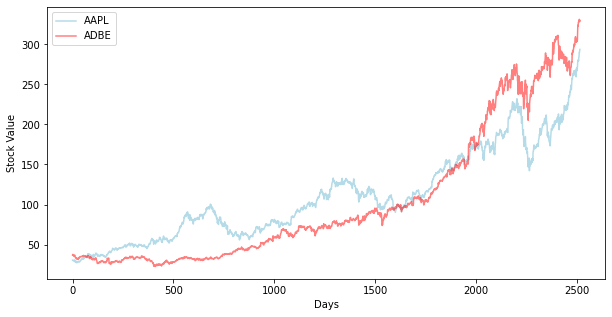

In [1988]:
ax1 = stock['AAPL'].plot(color="lightblue", alpha=0.9)
ax1.set(xlabel='Days', ylabel='Stock Value')
stock['ADBE'].plot(color="red", alpha=0.5, ax=ax1)
plt.legend(['AAPL', 'ADBE'], loc='upper left')

## Data preparation

### Data selection

*Select date, day and stocks for the portfolio, remember that Date and Day are needed here.*

In [1989]:
# # Uncomment the code to run this Model

# # Original Values
# stocks = ['Date', 'Day', 'AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT'] # Try just IBM
# labels = ['IBM', 'AAPL'] # Try others, e.g. AAPL or HPQ (but add it above)

# horizon = 2 # Number of days, the model is going to predict.

# # Select raw_portfolio
# raw_portfolio = stock[stocks]

# print('Selected stocks: ', ', '.join(stocks))
# print('Prediction target: ', labels)
# print('Selected data shape: ', raw_portfolio.shape)
# raw_portfolio.describe(include='all')

# Original Experiment ----> Label = IBM

## Stocks and Horizon

In [1990]:
# # Uncomment the code to run this Model

# # Original Values
# stocks = ['Date', 'Day', 'AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT'] # Try just IBM
# labels = ['IBM'] # Try others, e.g. AAPL or HPQ (but add it above)

# horizon = 2 # Number of days, the model is going to predict.

# # Select raw_portfolio
# raw_portfolio = stock[stocks]

# print('Selected stocks: ', ', '.join(stocks))
# print('Prediction target: ', labels)
# print('Selected data shape: ', raw_portfolio.shape)
# raw_portfolio.describe(include='all')

# Task 2 ---> Univariate


#### **RUN #3** **and** **RUN #4**

In [1]:
# # Uncomment the code to run this Model

# stocks = ['Date', 'Day', 'IBM']
# labels = ['IBM'] 

# horizon = 2 

# # Select raw_portfolio
# raw_portfolio = stock[stocks]

# print('Selected stocks: ', ', '.join(stocks))
# print('Prediction target: ', labels)
# print('Selected data shape: ', raw_portfolio.shape)
# raw_portfolio.describe(include='all')

#### **RUN #5 and RUN#6** 

In [1992]:
# # Uncomment the code to run this Model


# stocks = ['Date', 'Day', 'MSFT']
# labels = ['MSFT'] 

# horizon = 2

# # Select raw_portfolio
# raw_portfolio = stock[stocks]

# print('Selected stocks: ', ', '.join(stocks))
# print('Prediction target: ', labels)
# print('Selected data shape: ', raw_portfolio.shape)
# raw_portfolio.describe(include='all')

# Task 3 ---> Multivariate

#### **RUN #7, RUN #8, RUN #9 and RUN #10**

In [1993]:
# # Uncomment the code to run this Model

# stocks = ['Date', 'Day', 'HPQ', 'INTC','AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT']
# labels = ['GOOGL', 'AMZN']

# horizon = 2 # Number of days, the model is going to predict.

# # Select raw_portfolio
# raw_portfolio = stock[stocks]

# print('Selected stocks: ', ', '.join(stocks))
# print('Prediction target: ', labels)
# print('Selected data shape: ', raw_portfolio.shape)
# raw_portfolio.describe(include='all')

# Task 4 ---> Multilabel

#### **RUN #11, RUN #12, RUN #13, RUN #14, RUN #15, RUN #16, RUN #17**

In [2043]:
# # Uncomment the code to run this Model


# stocks = ['Date', 'Day', 'HPQ', 'INTC','AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT']
# labels = ['ADBE', 'AAPL']

# horizon = 2 # Number of days, the model is going to predict.

# # Select raw_portfolio
# raw_portfolio = stock[stocks]

# print('Selected stocks: ', ', '.join(stocks))
# print('Prediction target: ', labels)
# print('Selected data shape: ', raw_portfolio.shape)
# raw_portfolio.describe(include='all')

# Task 6 ---> Horizon = 7

#### **RUN #18**

In [1995]:
# # Uncomment the code to run this Model

# stocks = ['Date', 'Day', 'HPQ', 'INTC','AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT']
# labels = ['ADBE', 'AAPL']

# horizon = 7 # Number of days, the model is going to predict.

# # Select raw_portfolio
# raw_portfolio = stock[stocks]

# print('Selected stocks: ', ', '.join(stocks))
# print('Prediction target: ', labels)
# print('Selected data shape: ', raw_portfolio.shape)
# raw_portfolio.describe(include='all')

#### **RUN #19**

In [1996]:
# # Uncomment the code to run this Model

# stocks = ['Date', 'Day', 'MSFT']
# labels = ['MSFT'] 

# horizon = 7

# # Select raw_portfolio
# raw_portfolio = stock[stocks]

# print('Selected stocks: ', ', '.join(stocks))
# print('Prediction target: ', labels)
# print('Selected data shape: ', raw_portfolio.shape)
# raw_portfolio.describe(include='all')

#### **RUN #20**

In [1997]:
stocks = ['Date', 'Day', 'HPQ', 'INTC','AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT']
labels = ['GOOGL', 'AMZN']

horizon = 7

# Select raw_portfolio
raw_portfolio = stock[stocks]

print('Selected stocks: ', ', '.join(stocks))
print('Prediction target: ', labels)
print('Selected data shape: ', raw_portfolio.shape)
raw_portfolio.describe(include='all')

# Data Cleansing

### Imputation of missing values (if needed)

*Note that we need to check if the stock data has any missing data.*<br>

In [1998]:
print('Records:\t', len(raw_portfolio))
missing = raw_portfolio.isnull().sum()
print(missing.sort_values(ascending=False))

Records:	 2516
MSFT     0
IBM      0
GOOGL    0
AMZN     0
ADBE     0
AAPL     0
INTC     0
HPQ      0
Day      0
Date     0
dtype: int64


### Resample and interpolate missing values

*We need to resample the contents of all Pandas (sub) data-frames by removing empty rows and columns (if any),<br>
and then up-sampling the data frame by interpolating records in 1-day intervals.*

In [1999]:
def stock_resample(df):

    # Remove all empty rows.
    df_res = df.dropna(how='all')
    
    # Create a sorted index from date
    df_res['Date'] = pd.to_datetime(df_res['Date'])
    df_res.index = df_res['Date']
    df_res.sort_index(inplace=True)
    del df_res['Date']

    # Upsample so the time-series has data for every day
    df_res = df_res.resample('D')

    # Fill in missing values by interpolating in between existing records
    df_res = df_res.interpolate(method='values')

    # Remove any empty rows that may have been created in this process
    df_res = df_res.dropna(how='all')
    
    # Columns no longer needed
    del df_res['Day']

    return df_res

*Resample all stocks*

In [2000]:
portfolio_x = stock_resample(raw_portfolio)

*Observe missing dates in the original table - we should have no missing values*

In [2001]:
raw_portfolio[(raw_portfolio['Date'] >= '2010-01-07') & (raw_portfolio['Date'] <= '2010-01-12')]

,Date,Day,HPQ,INTC,AAPL,ADBE,AMZN,GOOGL,IBM,MSFT
3,2010-01-07,14615,23.705723,20.600000,30.082857,36.889999,130.000000,297.347351,129.550003,30.450001
4,2010-01-08,14616,23.882833,20.830000,30.282858,36.689999,133.520004,301.311310,130.850006,30.660000
5,2010-01-11,14619,23.810173,20.950001,30.015715,36.209999,130.309998,300.855865,129.479996,30.270000
6,2010-01-12,14620,23.601271,20.610001,29.674286,35.660000,127.349998,295.535522,130.509995,30.070000


*Observe that missing values have been interpolated*

In [2002]:
portfolio_x['2010-01-07':'2010-01-12']

,HPQ,INTC,AAPL,ADBE,AMZN,GOOGL,IBM,MSFT
Date,,,,,,,,
2010-01-07,23.705723,20.600000,30.082857,36.889999,130.000000,297.347351,129.550003,30.450001
2010-01-08,23.882833,20.830000,30.282858,36.689999,133.520004,301.311310,130.850006,30.660000
2010-01-09,23.858613,20.870000,30.193810,36.529999,132.450002,301.159495,130.393336,30.530000
2010-01-10,23.834393,20.910000,30.104762,36.369999,131.380000,301.007680,129.936666,30.400000
2010-01-11,23.810173,20.950001,30.015715,36.209999,130.309998,300.855865,129.479996,30.270000
2010-01-12,23.601271,20.610001,29.674286,35.660000,127.349998,295.535522,130.509995,30.070000


*The labels come from the original data but time-shifted to the left (past)*

In [2003]:
portfolio_y = portfolio_x[labels].shift(-horizon)

*As we shift data to the left (past), examples from the beginning of the series will drop off, and those from the end will become undefined*

In [2004]:
display_side_by_side(
    pd.concat([portfolio_x[labels].head(horizon + 10)], keys=['Original series'], axis=1),
    pd.concat([portfolio_y.head(10)], keys=['Start of new series'], axis=1),
    pd.concat([portfolio_y.tail(horizon+10)], keys=['End of new series'], axis=1))

Original series 
 
 
 
 ADBE 
 AAPL 
 
 
 Date 
 
 
 
 
 
 
 2010-01-04 
 37.090000 
 30.572857 
 
 
 2010-01-05 
 37.700001 
 30.625713 
 
 
 2010-01-06 
 37.619999 
 30.138571 
 
 
 2010-01-07 
 36.889999 
 30.082857 
 
 
 2010-01-08 
 36.689999 
 30.282858 
 
 
 2010-01-09 
 36.529999 
 30.193810 
 
 
 2010-01-10 
 36.369999 
 30.104762 
 
 
 2010-01-11 
 36.209999 
 30.015715 
 
 
 2010-01-12 
 35.660000 
 29.674286 
 
 
 2010-01-13 
 36.279999 
 30.092857 
 
 
 2010-01-14 
 35.900002 
 29.918571 
 
 
 2010-01-15 
 35.869999 
 29.418571 
 
 
 
 
 
 
 Start of new series 
 
 
 
 ADBE 
 AAPL 
 
 
 Date 
 
 
 
 
 
 
 2010-01-04 
 37.619999 
 30.138571 
 
 
 2010-01-05 
 36.889999 
 30.082857 
 
 
 2010-01-06 
 36.689999 
 30.282858 
 
 
 2010-01-07 
 36.529999 
 30.193810 
 
 
 2010-01-08 
 36.369999 
 30.104762 
 
 
 2010-01-09 
 36.209999 
 30.015715 
 
 
 2010-01-10 
 35.660000 
 29.674286 
 
 
 2010-01-11 
 36.279999 
 30.092857 
 
 
 2010-01-12 
 35.900002 
 29.918571 
 
 
 2010-01-13 
 35.869999 
 29.418571 
 
 
 
 
 
 
 End of new series 
 
 
 
 ADBE 
 AAPL 
 
 
 Date 
 
 
 
 
 
 
 2019-12-20 
 328.503337 
 282.480001 
 
 
 2019-12-21 
 328.950012 
 284.000000 
 
 
 2019-12-22 
 329.640015 
 284.269989 
 
 
 2019-12-23 
 330.420013 
 287.089996 
 
 
 2019-12-24 
 331.200012 
 289.910004 
 
 
 2019-12-25 
 330.790009 
 289.799988 
 
 
 2019-12-26 
 329.973338 
 290.373322 
 
 
 2019-12-27 
 329.156667 
 290.946655 
 
 
 2019-12-28 
 328.339996 
 291.519989 
 
 
 2019-12-29 
 329.809998 
 293.649994 
 
 
 2019-12-30 
 NaN 
 NaN 
 
 
 2019-12-31 
 NaN 
 NaN

### Data preparation for Keras RNN (NumPy arrays)

*We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.*

In [2005]:
# Correct predictors x and targets/labels y for the horizon shift
x_data = portfolio_x.values[0:-horizon]
y_data = portfolio_y.values[:-horizon]

# Calculate training and testing partition sizes
num_data = len(x_data)
train_split = 0.7
num_train = int(train_split * num_data)
num_test = num_data - num_train

# Define boundaries for training and testing
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

# Identify time events to be used in training
num_x_events = x_data.shape[1]
num_y_events = y_data.shape[1]

print("Original x shape:", x_data.shape, ", New x shape:", x_train.shape, x_test.shape)
print("Original y shape:", y_data.shape, ", New y shape:", y_train.shape, y_test.shape)

Original x shape: (3647, 8) , New x shape: (2552, 8) (1095, 8)
Original y shape: (3647, 2) , New y shape: (2552, 2) (1095, 2)


### Scale data

*Before this data can be used by neural net, its X and Y values need scaling to [0:1] range.*
*We will need to estimate the future stock growth across the portfolio and scale data to a smaller range, e.g. [0:0.4], then we will apply the scaler to all new data without any clipping (which could cause problems).*<br>
<font color="red">*We must check that the new/test data does not go (much) over the [0:1] range!*</font>

In [2006]:
print("Before train x scaling - Min:", np.min(x_train), ", Max:", np.max(x_train))
print("Before test x scaling - Min:", np.min(x_test), ", Max:", np.max(x_test))
x_scaler = MinMaxScaler(feature_range=(0, 0.3), copy=True)
x_train_scaled = x_scaler.fit_transform(x_train).clip(0, 1)
x_test_scaled = x_scaler.transform(x_test).clip(0, 1)
print("After train x scaling - Min:", np.min(x_train_scaled), ", Max:", np.max(x_train_scaled))
print("After test x scaling - Min:", np.min(x_test_scaled), ", Max:", np.max(x_test_scaled))

Before train x scaling - Min: 5.317893028259277 , Max: 844.3599853515625
Before test x scaling - Min: 14.579999923706055 , Max: 2039.510009765625
After train x scaling - Min: 0.0 , Max: 0.30000000000000004
After test x scaling - Min: 0.0 , Max: 1.0


In [2007]:
print("Before train y scaling - Min:", np.min(y_train), ", Max:", np.max(y_train))
print("Before test y scaling - Min:", np.min(y_test), ", Max:", np.max(y_test))
y_scaler = x_scaler
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print("After train y scaling - Min:", np.min(y_train_scaled), ", Max:", np.max(y_train_scaled))
print("After test y scaling - Min:", np.min(y_test_scaled), ", Max:", np.max(y_test_scaled))

Before train y scaling - Min: 22.690000534057614 , Max: 133.0
Before test y scaling - Min: 103.21500015258789 , Max: 331.20001220703125
After train y scaling - Min: 0.0 , Max: 0.3
After test y scaling - Min: 0.2516455797201059 , Max: 1.0503064755678737


In [2008]:
# Print a week of Xs and Ys side by side
display_side_by_side(
    pd.concat([pd.DataFrame(x_train_scaled, columns=portfolio_x.columns).head(10)], keys=['X'], axis=1),
    pd.concat([pd.DataFrame(y_train_scaled, columns=portfolio_y.columns).head(10)], keys=['Y'], axis=1))

X 
 
 
 
 HPQ 
 INTC 
 AAPL 
 ADBE 
 AMZN 
 GOOGL 
 IBM 
 MSFT 
 
 
 
 
 0 
 0.285494 
 0.047137 
 0.008915 
 0.049024 
 0.010312 
 0.046366 
 0.044717 
 0.058656 
 
 
 1 
 0.287036 
 0.046990 
 0.009066 
 0.051101 
 0.010634 
 0.045695 
 0.039816 
 0.058729 
 
 
 2 
 0.283602 
 0.045962 
 0.007681 
 0.050828 
 0.009639 
 0.041870 
 0.037213 
 0.057326 
 
 
 3 
 0.283742 
 0.043025 
 0.007523 
 0.048343 
 0.008722 
 0.038427 
 0.035835 
 0.054962 
 
 
 4 
 0.286475 
 0.046402 
 0.008091 
 0.047662 
 0.010157 
 0.040353 
 0.039816 
 0.056513 
 
 
 5 
 0.286101 
 0.046990 
 0.007838 
 0.047118 
 0.009721 
 0.040279 
 0.038418 
 0.055553 
 
 
 6 
 0.285728 
 0.047577 
 0.007585 
 0.046573 
 0.009284 
 0.040205 
 0.037019 
 0.054592 
 
 
 7 
 0.285354 
 0.048164 
 0.007332 
 0.046028 
 0.008848 
 0.040132 
 0.035620 
 0.053632 
 
 
 8 
 0.282130 
 0.043172 
 0.006362 
 0.044156 
 0.007641 
 0.037547 
 0.038775 
 0.052155 
 
 
 9 
 0.283882 
 0.048311 
 0.007551 
 0.046266 
 0.008359 
 0.036723 
 0.037917 
 0.054223 
 
 
 
 
 
 
 Y 
 
 
 
 ADBE 
 AAPL 
 
 
 
 
 0 
 0.050828 
 0.007681 
 
 
 1 
 0.048343 
 0.007523 
 
 
 2 
 0.047662 
 0.008091 
 
 
 3 
 0.047118 
 0.007838 
 
 
 4 
 0.046573 
 0.007585 
 
 
 5 
 0.046028 
 0.007332 
 
 
 6 
 0.044156 
 0.006362 
 
 
 7 
 0.046266 
 0.007551 
 
 
 8 
 0.044973 
 0.007056 
 
 
 9 
 0.044871 
 0.005635

## Create a data generator

*As the training-data could potentially have 1000s of observations, so instead of training the neural net on the complete sequences, we will use a generator function to create batches of shorter sub-sequences picked at random from training data.*

*Use a large batch-size to keep the GPU busy. Or we can pick a smaller batch size to improve accuracy and performance. You may have to adjust this number depending on your GPU, its RAM and your sequence_length.

In [2009]:
batch_size = 512
sequence_length = 21 # 6 weeks x 7 days

*Generator function*

In [2010]:
def batch_generator(batch_size, sequence_length, nt, nx, ny):
    while True:
        # Allocate a new array for the batch of input-events.
        x_shape = (batch_size, sequence_length, nx)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-events.
        y_shape = (batch_size, sequence_length, ny)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(nt - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

*Create the batch-generator*

In [2011]:
# fix random seed for (near) reproducibility
np.random.seed(7)

generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length, 
                            nt=num_train, nx=num_x_events, ny=num_y_events)

*Create validation set*

Note: Model validation will be performed after each epoch and when the model improves its weights will be saved.<br>
For training, we will use the batch-generator, however, for validation we will use the entire sequence, i.e. including x and y.

In [2012]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

*Test generator*

X batch shape = (512, 28, 8) , Input size = 224
Y batch shape = (512, 28, 2) , Output size = 56


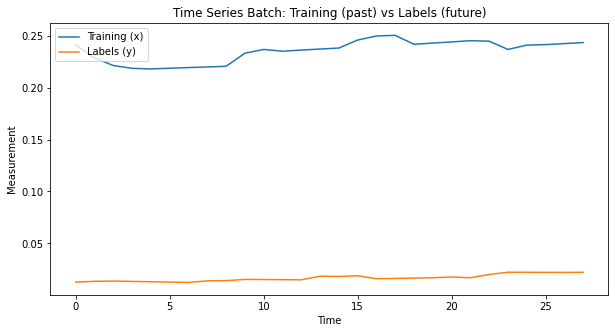

In [2013]:
batch = 0  # Some sequence in the batch
event = 0  # Some event from input-events

x_batch, y_batch = next(generator)
print('X batch shape =', x_batch.shape, ', Input size =', x_batch.shape[1]*x_batch.shape[2])
print('Y batch shape =', y_batch.shape, ', Output size =', y_batch.shape[1]*y_batch.shape[2])

x_seq = x_batch[batch, :, event]
y_seq = y_batch[batch, :, event]
plt.plot(x_seq)
plt.plot(y_seq)
plt.title('Time Series Batch: Training (past) vs Labels (future)')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['Training (x)', 'Labels (y)'], loc='upper left')

## Create the Recurrent Neural Network

*We will create the forecasting model using a Recurrent Neural Network, such as vanilla RNN, LSTM and GRU.*

*Network parameters: note that there is 3600 training examples and our sequence is 42 examples in length. As the batch-size is 256 sequences, each step in an epoch will run 256x42 examples. So the possibility of overtraining is huge unless we control these parameters carefully.*

In [2014]:
epochs = 200
steps_per_epoch = 100
warmup_steps = 7 # For custom loss function

### Loss Function

*We will use a custom `Mean Squared Error (MSE)` as the loss-function.*

The function will deal in a special way with events at the beginning of a sequence. As the model has seen input-events for a few time-steps only, so its generated output may be very inaccurate. Using the standard loss function which utilises the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of `warmup_steps` time-steps where we don't use its accuracy in the loss-function.

In [2015]:
# The shape of both input tensors are: [batch_size, sequence_length, num_y_events]
def loss_mse_warmup(y_true, y_pred):
    # Ignore the "warmup" parts of the sequences
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    mse = mean(square(y_true_slice - y_pred_slice))   
    return mse

### RNN Models

<font color="red">**Add more models here as needed**</font>

In [2016]:
def rnn_model_gru_sigmoid_1(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=256,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))
    model.add(Dense(num_y_events, activation='sigmoid'))
    model.summary()
    return(model)

In [2017]:
def rnn_model_gru_sigmoid_2(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=512,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))
    model.add(BatchNormalization())
    model.add(Dense(num_y_events, activation='sigmoid'))
    model.summary()
    return(model)

In [2018]:
def rnn_model_gru_layers(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=512,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))
    model.add(GRU(units=256,
                  return_sequences=True))
    model.add(Dense(num_y_events, activation='sigmoid'))
    model.summary()
    return(model)

In [2019]:
# Alternatively, we can use a linear activation function to allow for the output 
# to take on arbitrary values. However, when more layers are in use, it may be 
# necessary to initialize weights with smaller values to avoid `NaN` values

from tensorflow.python.keras.initializers import RandomUniform

# This model will keep very small weights to start with
def rnn_model_gru_linear(num_x_events, num_y_events):
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model = Sequential()
    model.add(GRU(units=512,
                    return_sequences=True,
                    input_shape=(None, num_x_events,)))
    model.add(Dense(num_y_events, activation='linear',
                    kernel_initializer=init))
    model.summary()
    return(model)

# Task 2 ---> Univariate Models


### **RUN #3**

In [2020]:
def rnn_model_gru_sigmoid_3(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=512,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))
    model.add(BatchNormalization())
    model.add(Dense(num_y_events, activation='sigmoid'))
    model.summary()
    return(model)

### **RUN #4**

In [2021]:
from tensorflow.python.keras.initializers import RandomUniform

# This model will keep very small weights to start with
def rnn_model_gru_linear_4(num_x_events, num_y_events):
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model = Sequential()
    model.add(GRU(units=512,
                    return_sequences=True,
                    input_shape=(None, num_x_events,)))
    model.add(Dense(num_y_events, activation='linear',
                    kernel_initializer=init))
    model.summary()
    return(model)

### **RUN #5**

In [2022]:
def rnn_model_gru_sigmoid_5(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=512,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))
    model.add(BatchNormalization())
    model.add(Dense(num_y_events, activation='sigmoid'))
    model.summary()
    return(model)

### **RUN #6**

In [2023]:
from tensorflow.python.keras.initializers import RandomUniform

# This model will keep very small weights to start with
def rnn_model_gru_linear_6(num_x_events, num_y_events):
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model = Sequential()
    model.add(GRU(units=512,
                    return_sequences=True,
                    input_shape=(None, num_x_events,)))
    model.add(Dense(num_y_events, activation='linear',
                    kernel_initializer=init))
    model.summary()
    return(model)

# Task 3 ---> Multivariate Models


#### **RUN #7 and RUN #8**

In [2024]:
def rnn_model_gru_sigmoid_7(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=512,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))
    model.add(GRU(units=256,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))    
    model.add(BatchNormalization())
    model.add(Dense(num_y_events, activation='sigmoid'))
    model.summary()
    return(model)

#### **RUN #9 and RUN #10**

In [2025]:
from tensorflow.python.keras.initializers import RandomUniform

# This model will keep very small weights to start with
def rnn_model_gru_linear_9(num_x_events, num_y_events):
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model = Sequential()
    model.add(GRU(units=512,
                    return_sequences=True,
                    input_shape=(None, num_x_events,)))
    model.add(Dense(num_y_events, activation='linear',
                    kernel_initializer=init))
    model.summary()
    return(model)

# Task 4 ---> MultiLabel Models


#### **RUN #11**

In [2026]:
def rnn_model_gru_sigmoid_11(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=256,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))
    model.add(Dense(num_y_events, activation='sigmoid'))
    model.summary()
    return(model)

#### **RUN #12 and RUN #13**

In [2027]:
def rnn_model_gru_sigmoid_12(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=512,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))
    model.add(GRU(units=256,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))    
    model.add(Dense(num_y_events, activation='sigmoid'))
    model.summary()
    return(model)

#### **RUN #14**

In [2028]:
from tensorflow.python.keras.initializers import RandomUniform

# This model will keep very small weights to start with
def rnn_model_gru_linear_16(num_x_events, num_y_events):
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model = Sequential()
    model.add(GRU(units=512,
                    return_sequences=True,
                    input_shape=(None, num_x_events,)))    
    model.add(Dense(num_y_events, activation='linear',
                    kernel_initializer=init))
    model.summary()
    return(model)

#### **RUN #15**

In [2029]:
from tensorflow.python.keras.initializers import RandomUniform

# This model will keep very small weights to start with
def rnn_model_gru_linear_15(num_x_events, num_y_events):
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model = Sequential()
    model.add(GRU(units=512,
                    return_sequences=True,
                    input_shape=(None, num_x_events,)))
    model.add(BatchNormalization())    
    model.add(GRU(units=256,
                    return_sequences=True,
                    input_shape=(None, num_x_events,)))
    model.add(BatchNormalization())
    model.add(Dense(num_y_events, activation='linear',
                    kernel_initializer=init))
    model.summary()
    return(model)

# TASK 5 and 6 OPTIMIZE and Horizon change

#### **RUN #16, RUN #17 and RUN #18**

In [2030]:
from tensorflow.python.keras.initializers import RandomUniform

# This model will keep very small weights to start with
def rnn_model_gru_linear_16(num_x_events, num_y_events):
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model = Sequential()
    model.add(GRU(units=512,
                    return_sequences=True,
                    input_shape=(None, num_x_events,)))
    model.add(BatchNormalization())    
    model.add(Dense(num_y_events, activation='linear',
                    kernel_initializer=init))
    model.summary()
    return(model)

#### **RUN #19**

In [2031]:
from tensorflow.python.keras.initializers import RandomUniform

# This model will keep very small weights to start with
def rnn_model_gru_linear_6(num_x_events, num_y_events):
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model = Sequential()
    model.add(GRU(units=512,
                    return_sequences=True,
                    input_shape=(None, num_x_events,)))
    model.add(Dense(num_y_events, activation='linear',
                    kernel_initializer=init))
    model.summary()
    return(model)

#### **RUN #20**

In [2032]:
from tensorflow.python.keras.initializers import RandomUniform

# This model will keep very small weights to start with
def rnn_model_gru_linear_9(num_x_events, num_y_events):
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model = Sequential()
    model.add(GRU(units=512,
                    return_sequences=True,
                    input_shape=(None, num_x_events,)))
    model.add(Dense(num_y_events, activation='linear',
                    kernel_initializer=init))
    model.summary()
    return(model)

### Create and compile the model

*Define a few optimizers to chose from. Note that this is the initial learning rate, which will be dynamic.*

In [2033]:
opt_sgd_1 = SGD(lr=0.01, momentum=0.0, nesterov=False)
opt_sgd_2 = SGD(lr=0.05, momentum=0.1, nesterov=False) # Good results with ReduceLROnPlateau
opt_rmsprop_1 = RMSprop(lr=0.005, rho=0.9, decay=0.5, epsilon=1e-07)
opt_rmsprop_2 = RMSprop(lr=0.01, rho=0.9, decay=0.1, epsilon=1e-07)
opt_adadelta_1 = Adadelta(lr=0.001, rho=0.95, epsilon=1e-07)
opt_adadelta_2 = Adadelta(lr=0.01, rho=0.99, epsilon=1e-07)
opt_adam_1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
opt_adam_2 = Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07)
opt_nadam = Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)

# Start collecting history, in case we train the model iteratively
rnn_hist = start_hist()

model = rnn_model_gru_linear_9(num_x_events, num_y_events)
model.compile(loss=loss_mse_warmup, optimizer=opt_adam_1, metrics=[metrics.mae])
# model.compile(loss='mean_squared_error', optimizer=opt_nadam, metrics=[metrics.mae])

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_45 (GRU)                 (None, None, 512)         801792    
_________________________________________________________________
batch_normalization_15 (Batc (None, None, 512)         2048      
_________________________________________________________________
dense_34 (Dense)             (None, None, 2)           1026      
Total params: 804,866
Trainable params: 803,842
Non-trainable params: 1,024
_________________________________________________________________


### Callback functions

*During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras*

In [2034]:
path_checkpoint = './gru_checkpoints/'

callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
        monitor='val_loss',
        verbose=1,
        save_weights_only=True,
        save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
        patience=10, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./gru_logs/',
        histogram_freq=0,
        write_graph=False)

# This callback reduces the learning-rate if the validation-loss has not improved as defined by `patience`.
# The learning-rate will be reduced by a `factor` (by multiplying) but no more than `min_lr`.
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
        factor=0.3,
        min_lr=1e-4,
        patience=5,
        min_delta = 1e-3,
        verbose=1)

keras_callbacks = [
        callback_early_stopping,
        #callback_tensorboard,
        callback_reduce_lr,
        callback_checkpoint
]

# Train the Recurrent Neural Network (RNN)

*Note that within each `epoch` batch-generator will randomly select sub-sequences from the training-set, controlled by `steps_per_epoch`.*

*Also note that the loss could become `NaN`, which can be resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.*

In [2035]:
%%time

# fix random seed for (near) reproducibility
np.random.seed(7)

# Fit the model
perform_indics = model.fit(x=generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_data,
        callbacks=keras_callbacks,
        verbose=1 # Use 0 or 2 to speed up
        )

# Add performance history
rnn_hist = collect_hist(rnn_hist, perform_indics.history)

Epoch 1/200
100/100 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0609
Epoch 00001: val_loss improved from inf to 0.22659, saving model to ./gru_checkpoints/
100/100 [==============================] - 3s 27ms/step - loss: 0.0110 - mean_absolute_error: 0.0609 - val_loss: 0.2266 - val_mean_absolute_error: 0.4218
Epoch 2/200
100/100 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0309
Epoch 00002: val_loss improved from 0.22659 to 0.22231, saving model to ./gru_checkpoints/
100/100 [==============================] - 2s 24ms/step - loss: 0.0023 - mean_absolute_error: 0.0309 - val_loss: 0.2223 - val_mean_absolute_error: 0.4196
Epoch 3/200
 98/100 [============================>.] - ETA: 0s - loss: 9.8016e-04 - mean_absolute_error: 0.0218
Epoch 00003: val_loss improved from 0.22231 to 0.16194, saving model to ./gru_checkpoints/
100/100 [==============================] - 2s 24ms/step - loss: 9.7320e-04 - mean_absolute_erro

*Plot training performance*

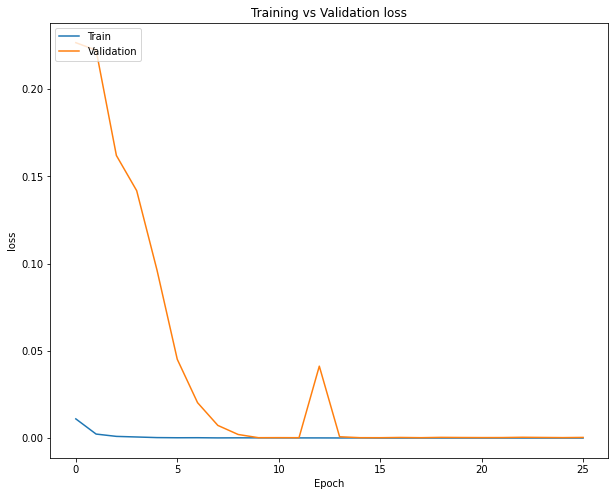

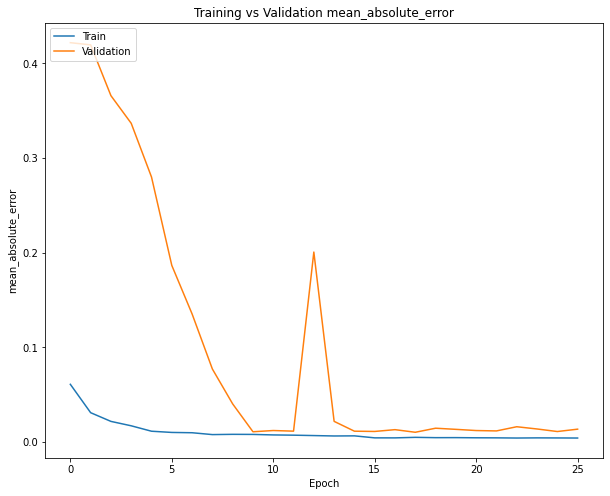

In [2036]:
plot_hist(rnn_hist, xsize=10, ysize=8)

### Load checkpoint

*As we used ModelCheckpoint callback, we can reload the last saved checkpoint, which had the best performance on the validation set*

In [2037]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Performance

*Training performance*

In [2038]:
result = model.evaluate(x=np.expand_dims(x_train_scaled, axis=0),
                        y=np.expand_dims(y_train_scaled, axis=0))
# We have several metrics so we want to show their names
print()
for res, metric in zip(result, model.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 0s 1ms/step - loss: 6.1783e-05 - mean_absolute_error: 0.0069

loss: 0.00006
mean_absolute_error: 0.00690


*Test performance*

In [2039]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
# We have several metrics so we want to show their names
print()
for res, metric in zip(result, model.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 0s 1ms/step - loss: 2.1808e-04 - mean_absolute_error: 0.0111

loss: 0.00022
mean_absolute_error: 0.01110


## Generate predictions

*This helper-function plots the predicted and true output-events*

In [2040]:
# Plot the predicted and true output-events.

def plot_comparison(start_idx, length=100, train=True, xlim=None, ylim=None):
    """
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-events for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-events.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-event.
    for event in range(len(labels)):
        # Get the output-event predicted by the model.
        event_pred = y_pred_rescaled[:, event]
        
        # Get the true output-event from the data-set.
        event_true = y_true[:, event]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two events.
        plt.plot(event_true, label='true')
        plt.plot(event_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        if (xlim): plt.xlim(xlim)
        if (ylim): plt.ylim(ylim)
        plt.ylabel(labels[event])
        plt.legend()
        plt.show()

*Plot predicted output-events, which show only output-events and not the input-events used to predict the output-events. The `time-shift` between the input-events and the output-events is held fixed as defined in the `horizon` variable. So the x-axis merely shows how many time-steps of the input-events have been seen by the predictive model so far.*

*The prediction is not very accurate for the initial time period because the model has seen very little input-data.
The model needs to "warm up" first and so we ignore this "warmup-period" (shown as a grey box) in loss calculation.*

**Example from the training data**

*Change the ylim=(yfrom, yto) and xlim=(xfrom, xto) to zoom in on the relevant parts of the chart.*

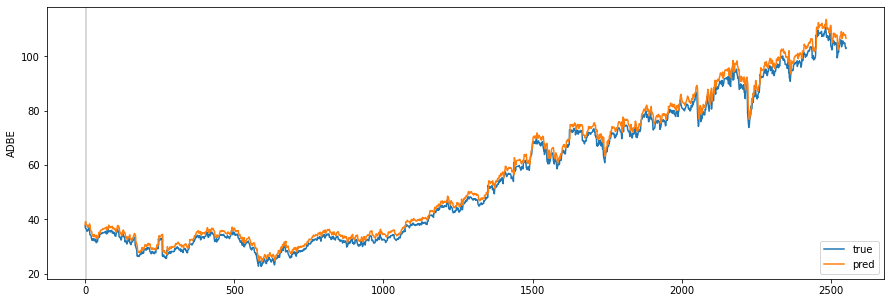

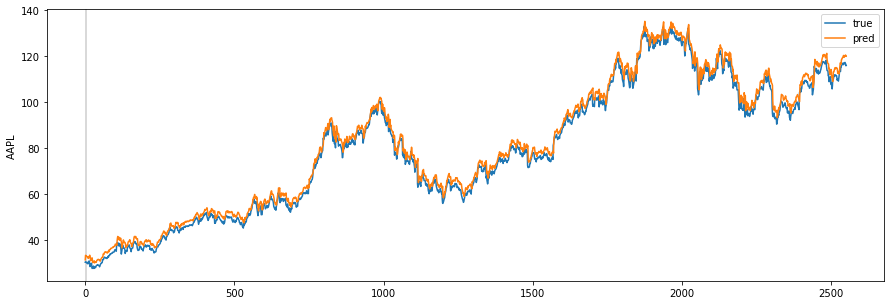

In [2041]:
# If you do see anything, delete ylim parameter
# plot_comparison(start_idx=0, length=3000, train=True, ylim=(20,250))
plot_comparison(start_idx=0, length=3000, train=True)

**Example from test data**

*Change the ylim=(yfrom, yto) and xlim=(xfrom, xto) to zoom in on the relevant parts of the chart.*

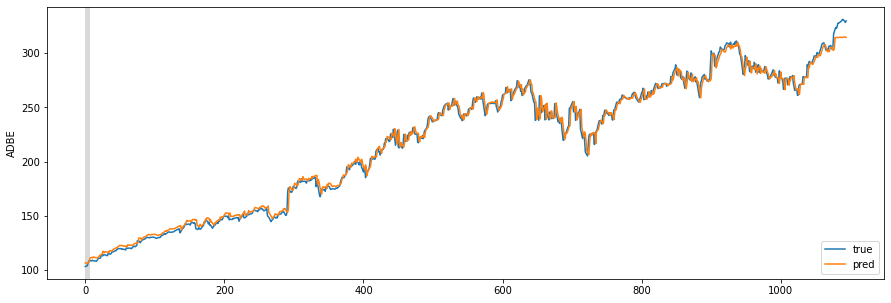

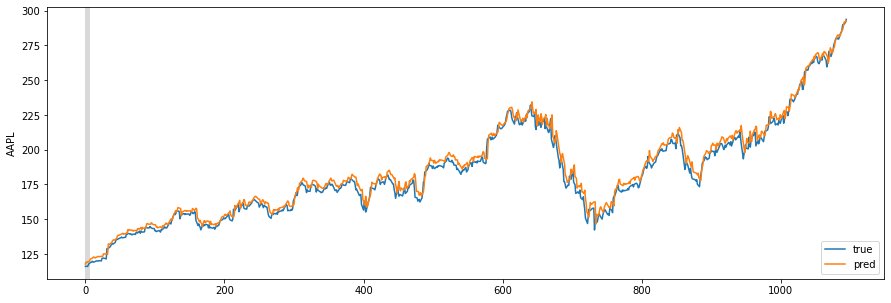

In [2042]:
# If you do see anything, delete ylim parameter
# plot_comparison(start_idx=0, length=1500, train=False, ylim=(50, 320))
plot_comparison(start_idx=0, length=1500, train=False)

<br>**All done! The report follows.**
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

# RNN models, experiments and their results

**Summary Table**

| Deep Learning Models | Best Executed Model | Batch Normalization | Stopped/Epochs | Batch | Optimizer | Activation | Train MAE | Test MAE |
| :- | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Artificial Nerual Network | basic_model_11 | No | 201/500 | 128 |  Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | tanh, Relu | 10,563 | 14,534 |
| Artificial Nerual Network | basic_model_9 | No | 102/500 | 128 |  Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | tanh, Relu | 11,224 | 14,731 |
| Convolutional Nerual Network | dae_model_2 | Yes | 90/90 | 256 |  Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07) | LeakyRelu, Sigmoid | 0.20245 | 0.05831 |
| Convolutional Nerual Network | dae_model_3 | Yes | 125/150 | 512 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | LeakyRelu, Sigmoid | 0.20255 | 0.05794 |
| Recurrent Nerual Network | rnn_model_gru_linear_9 | No | 50/50 | 256 |  Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07) | Linear | 0.00256 | 0.01250 |
| Recurrent Nerual Network | rnn_model_gru_linear_16 | Yes | 31/200 | 512 |  Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)	 | Linear | 0.00256 | 0.01250 |


**Strengths of Artificial Neural Network**

1. Storing information on the entire network.
2. Ability to work with incomplete knowledge.
3. Having fault tolerance.
4. Having a distributed memory.

**Weaknesses of Artificial Neural Network**

1. Hardware dependence.
2. Unexplained behavior of the network.
3. Determination of proper network structure.

**Strengths of Convolutional Neural Network**

1. Very High accuracy in image recognition problems.
2. Automatically detects the important features without any human supervision.
3. Weight sharing.


**Weaknesses of Convolutional Neural Network**

1. CNN do not encode the position and orientation of object.
2. Lack of ability to be spatially invariant to the input data.
3. Lots of training data is required.


**Strengths of Recurrent Neural Network**

1. An RNN remembers each and every information through time. It is useful in time series prediction only because of the feature to remember previous inputs as well. This is called 
Long Short Term Memory.
2. Recurrent neural network are even used with convolutional layers to extend the effective pixel neighborhood.

**Weaknesses of Recurrent Neural Network**

1. Gradient vanishing and exploding problems.
Training an RNN is a very difficult task.
2. It cannot process very long sequences if using tanh or relu as an activation function.


## RNN analysis and recommendation

<font color="red">**ANALYSIS**</font>

20 Experiments have been conducted and several Recurrent Neural Network (RNN) models to predict a stock value based on the movement of several stocks in a portfolio. 
It was observed that for all the modes such as Univariate and Multivariate, Linear Activation Function was able to generate a better result as compared to Sigmoid Function. Moreover, after experimenting with different optimisers, it was found that Adam and Nadam helped in reducing the errors of the models and were the best performing optimisers whereas Adadelta and RMSprop were performing very poorly. For Univariate mode, **rnn_model_gru_linear_4** has been selected whereas for Multivariate and Multilabel modes, **rnn_model_gru_linear_9, run #10** and **rnn_model_gru_linear_14, run #14** have been selected. These models are selected because of the following strengths. 

**Strengths of Selected Models:**

All of the Models generated uses a custom loss function which helps in minimizing the error by setting up a warm period. Moreover, Most of the selected Models contains only one layer which makes it computationally cheaper and faster.

**Weaknesses of Selected Models:**

It takes a lot of computational time to generate results due to its Recurrent Nature. Moreover, it is very difficult to train the model as it consumes a lot of time in training a lot of epochs. Moreover, it cannot process very long sequences when used with tan and rely as an activation function.


**Recommendations:**

**rnn_model_gru_linear_9** model would be recommended as a forecasting model for all the Modes such as Univariate, Multivariate and Multlabel.
This model has been recommended as it was performing very good with Horizon as 7. Moreover, this model could be further pushed by taking Horizon greater than 7 as well. To conclude this model would generate good results in less time, less cost and for more number of days.
<br>

## Summary of RNN experimental results

*Performance is measured as MAE comparing the the original and poredicted stock price.*

| Model# | Run# | Label | Batch | Horizon | Seq | Epochs | Steps/Epoch | Stopped/Epochs | Optimiser | LR reduce factor | Train MAE | Valid MAE |
| :- | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :- | -: | -: | -: |
| rnn_model_gru_sigmoid | 1 | IBM, AAPL |256 | 2 | 42 | 50 | 100 | 50/50 | SGD(lr=0.05, momentum=0.1, nesterov=False) | 0.3 | 0.02274 | 0.03080 |
| rnn_model_gru_sigmoid_2 | #2 (Task 1)M | IBM, AAPL | 256 | 2 | 42 | 50 | 100 | 15/50 | SGD(lr=0.05, momentum=0.1, nesterov=False) | 0.3 | 0.03482 | 0.02468 |
| rnn_model_gru_sigmoid_3 | #3 (Task 2)U | IBM | 256 | 2 | 42 | 50 | 100 | 23/50 | SGD(lr=0.05, momentum=0.1, nesterov=False) | 0.3 | 0.01735 | 0.01666 |
| rnn_model_gru_linear_4 | #4 (Task 2)U | IBM | 256 | 2 | 42 | 50 | 100 | 50/50 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.3 | 0.00512 | 0.00464 |
| rnn_model_gru_sigmoid_5 | #5 (Task 2)U | MSFT | 256 | 2 | 42 | 50 | 100 | 16/50 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.3 | 0.06167 | 0.04068 |
| rnn_model_gru_linear_6 | #6 (Task 2)U | MSFT | 256 | 2 | 42 | 50 | 100 | 15/50 | Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07) | 0.3 | 0.00370 | 0.01069 |
| rnn_model_gru_sigmoid_7 | #7 (Task 3)M | GOOGL, AMZN | 256 | 2 | 42 | 50 | 100 | 50/50 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.3 | 0.04051 | 0.04091 |
| rnn_model_gru_sigmoid_7 | #8 (Task 3)M | GOOGL, AMZN | 512 | 2 | 42 | 100 | 100 | 100/100 | Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07) | 0.3 | 0.06468 | 0.07468 |
| rnn_model_gru_linear_9 | #9 (Task 3)M | GOOGL, AMZN | 256 | 2 | 21 | 50 | 100 | 50/50 | Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07) | 0.3 | 0.00256 | 0.01250 |
| rnn_model_gru_linear_9 | #10 (Task 3)M | GOOGL, AMZN | 512 | 2 | 21 | 200 | 100 | 58/200 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.3 | 0.00268 | 0.00847 |
| rnn_model_gru_sigmoid_11 | #11 (Task 4)ML | ADBE, AAPL | 256 | 2 | 42 | 100 | 150 | 150/150 | RMSprop(lr=0.01, rho=0.9, decay=0.1, epsilon=1e-07) | 0.3 | 0.07731 | 0.29430 |
| rnn_model_gru_sigmoid_12 (Layer added) | #12 (Task 4)ML | ADBE, AAPL | 512 | 2 | 49 | 150 | 100 | 26/150 | Adadelta(lr=0.01, rho=0.99, epsilon=1e-07) | 0.3 | 0.34686 | 0.15927 |
| rnn_model_gru_sigmoid_12 (Layer added) | #13 (Task 4)ML | ADBE, AAPL | 512 | 2 | 49 | 150 | 100 | 150/150 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.3 | 0.00390 | 0.05117 |
| rnn_model_gru_linear_14 | #14(Task 4)ML | ADBE, AAPL | 512 | 2 | 42 | 100 | 100 | xx/100 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.5 | 0.00328 | 0.01551 |
| rnn_model_gru_linear_15 (Layer Added)(Batchnormalization added) | #15 (Task 4)ML | ADBE, AAPL | 256 | 2 | 42 | 200 | 100 | 31/100 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.3 | 0.06026 | 0.19631 |
| rnn_model_gru_linear_16 (Batchnormalization added) | #16 (Task 5)Optimize | ADBE, AAPL | 512 | 2 | 28 | 200 | 100 | 31/200 | Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07) | 0.3 | 0.00409 | 0.00931 |
| rnn_model_gru_linear_16 (Batchnormalization added) (Removed Custom Loss Function)| #17 (Task 5)Optimized | ADBE, AAPL | 512 | 2 | 28 | 200 | 100 | 33/200 | Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07) | 0.3 | 0.00309 | 0.01034 |
| rnn_model_gru_linear_16 (Batchnormalization added) (Horizon = 7) | #18 (Task 6)H | ADBE, AAPL | 512 | 7 | 28 | 200 | 100 | 32/200 | Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07) | 0.3 | 0.00959 | 0.01730 |
| rnn_model_gru_linear_4 | #19 (Task 6)H | MSFT | 256 | 7 | 42 | 50 | 100 | 18/50 | Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07) | 0.3 | 0.00649 | 0.01413 |
| rnn_model_gru_linear_9 | #20 (Task 6)H | GOOGL, AMZN | 512 | 7 | 21 | 200 | 100 | 30/200 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.3 | 0.00499 | 0.01588 |

## Details of RNN model training runs and test results

# RUN #2

***
***rnn_model_gru_sigmoid, run #2:***<pre>

**Model Description**
This Model contains GRU as a dense layer and is used to forecast IBM stock in Multivariate mode.

This run generates the best results and the graph indicates the quality of this forecasting.

**Optimizer used**
opt_sgd_2 = SGD(lr=0.05, momentum=0.1, nesterov=False)

**Data**
stocks = ['Date', 'Day', 'AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT'] 
labels = ['IBM']
horizon = 2

**Performance**
Train MAE: 0.02274
Valid MAE: 0.03080

**Training history and results**</pre>

***

**Training history**

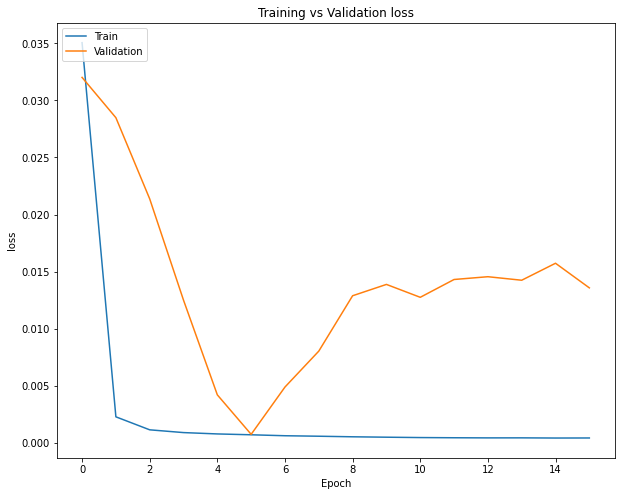

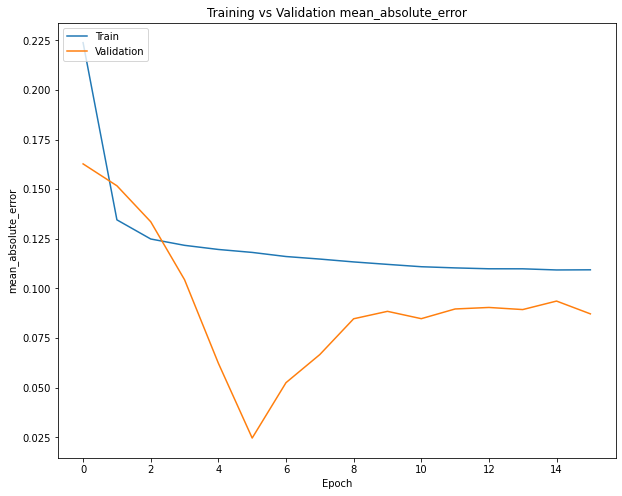


**Training Results**

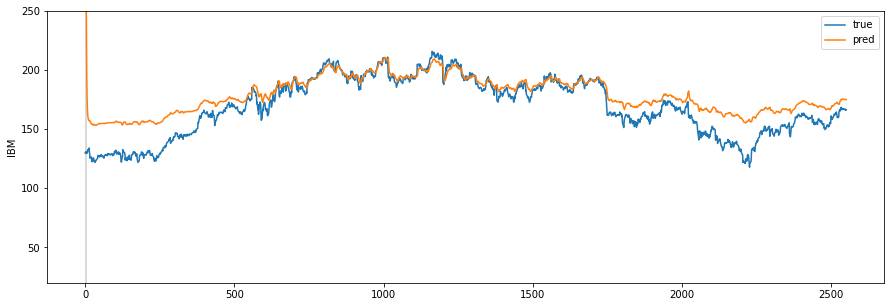


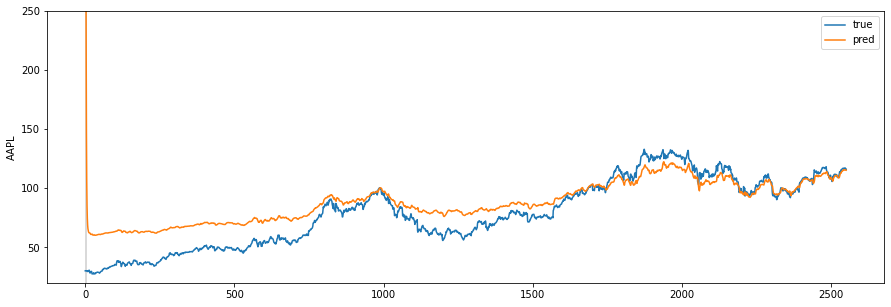

**Testing Results**

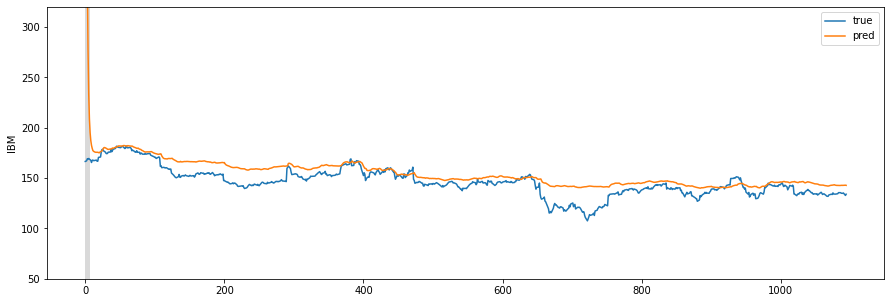

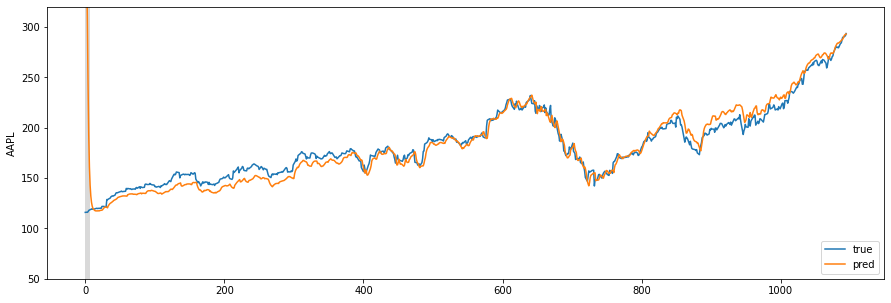

# Task 2 ---> Univariate ---> IBM

**Winner = rnn_model_gru_linear_4**

***rnn_model_gru_linear_4, run #4:***<pre>

**Model Description**
This Model contains GRU as a dense layer and is used to forecast a Univaraite stock as IBM. 
Also, Linear Activation function has been used.

This run generates the best results and the graph indicates the quality of this forecasting.

**Optimizer Used**
Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)	

**Data**
stocks = ['Date', 'Day', 'IBM']
labels = ['IMB']
horizon = 2

**Performance**
Train MAE: 0.00512
Valid MAE: 0.00464

**Training History**

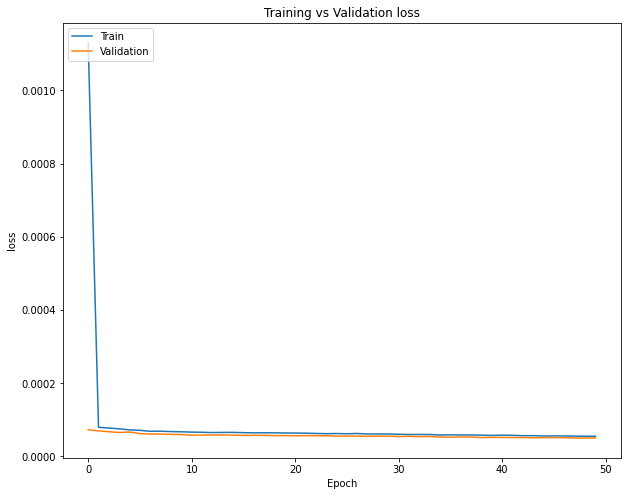

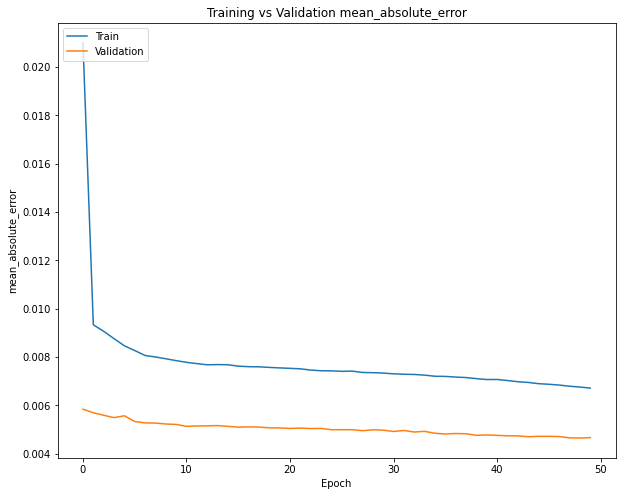

**Training Results**

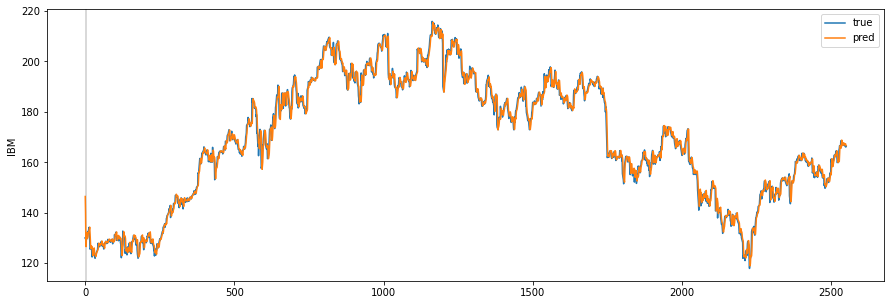

**Testing Results**

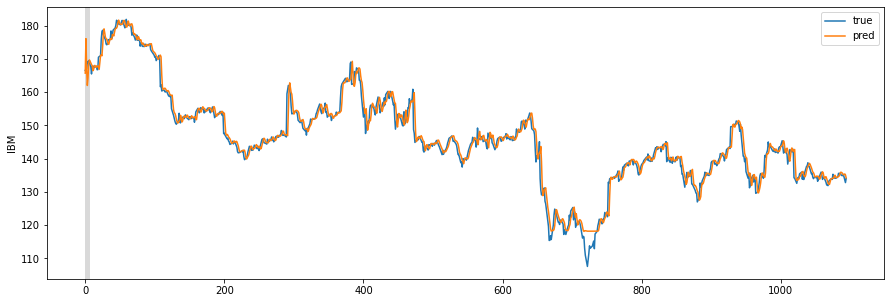

# Task 2 ---> Univariate ---> Microsoft

**Winner = rnn_model_gru_linear_6**

***rnn_model_gru_linear_1, run #4:***<pre>

**Model Description**
This Model contains GRU as a dense layer and is used to forecast a Univaraite stock as Microsoft. 
Also, Linear Activation function has been used.

This run generates the best results and the graph indicates the quality of this forecasting.

**Optimizer Used**
Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)	

**Data**
stocks = ['Date', 'Day', 'MSFT']
labels = ['MSFT']
horizon = 2

**Performance**
Train MAE: 0.00370
Valid MAE: 0.01069

**Training History**

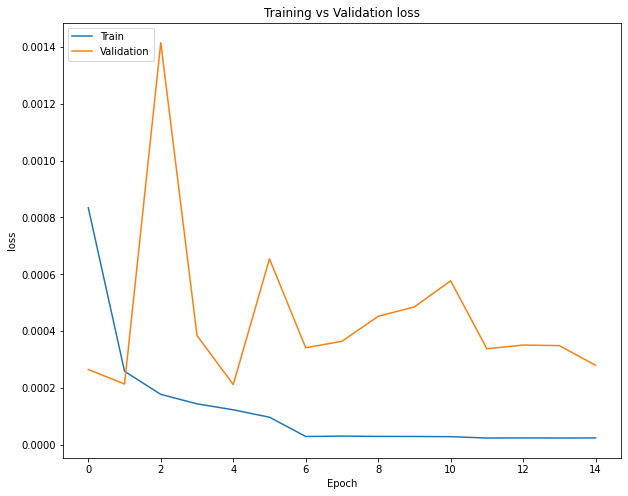

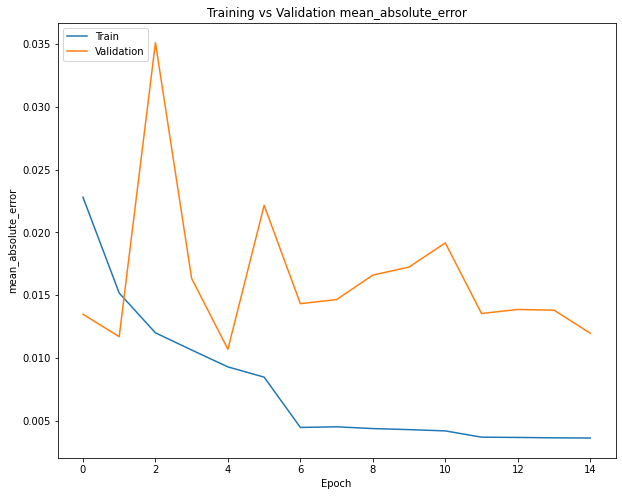



**Training Results**

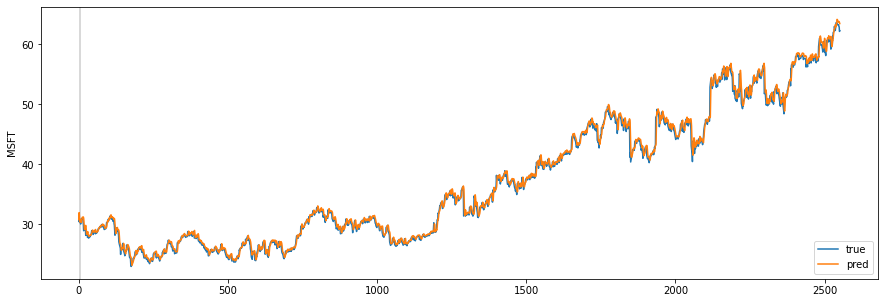

**Testing Results**

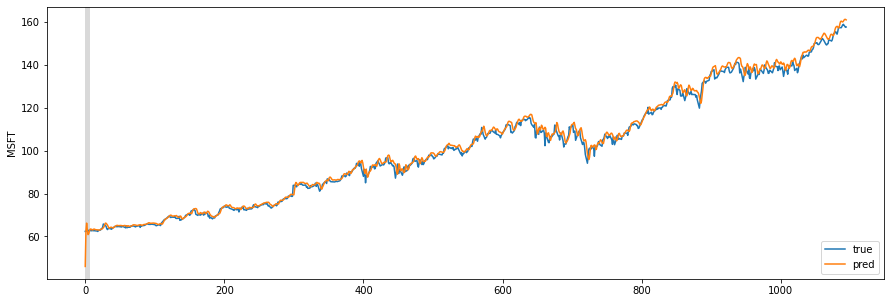


# Task 3 ---> MULTIVARIATE

***rnn_model_gru_linear_9, run #10:***<pre>

**Model Description**
This Model contains GRU as a dense layer and is used to forecast stocks as Google and Amazon. 
Also, Linear Activation function has been used.

This run generates the best results with valid MAE as 0.00847. 
Moreover, the graph indicates the quality of this forecasting.

**Optimizer Used**
Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

**Data**
stocks = ['Date', 'Day', 'HPQ', 'INTC','AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT']
labels = ['GOOGL', 'AMZN']
horizon = 2

**Performance**
Train MAE: 0.00268
Valid MAE: 0.00847

**Training History**

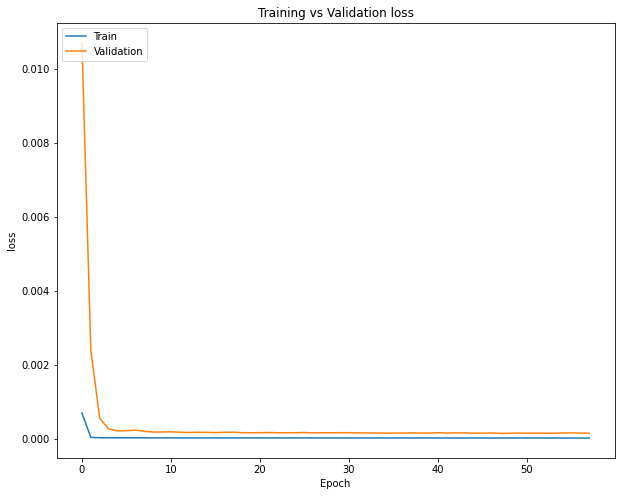

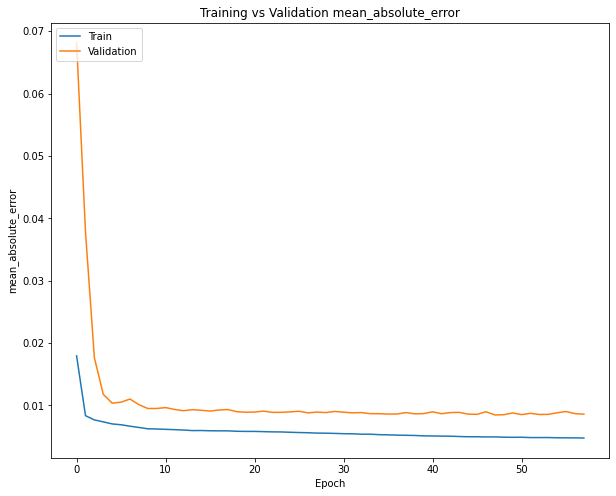

**Training Results**

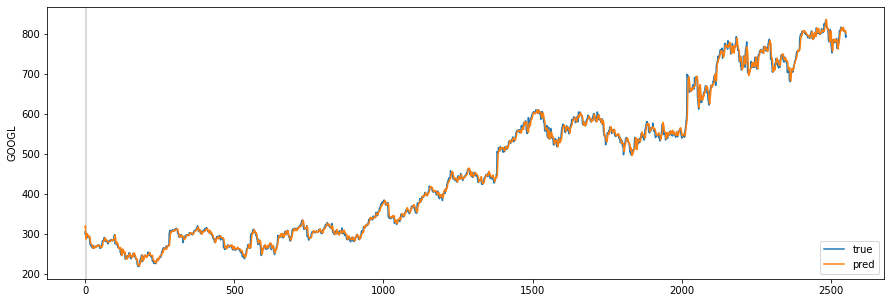


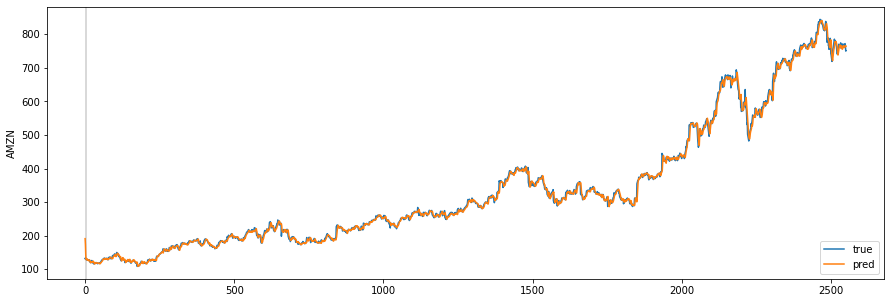

**Testing Results**

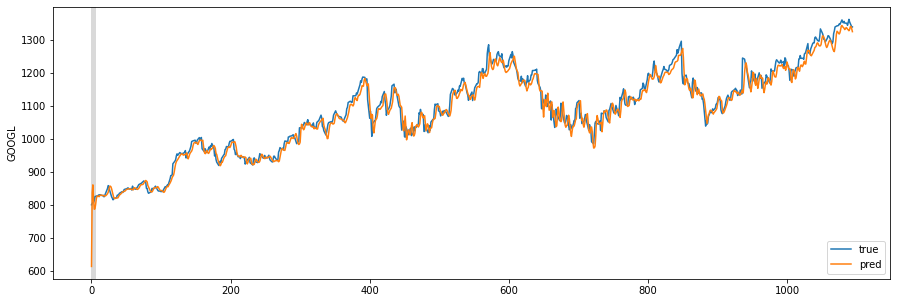

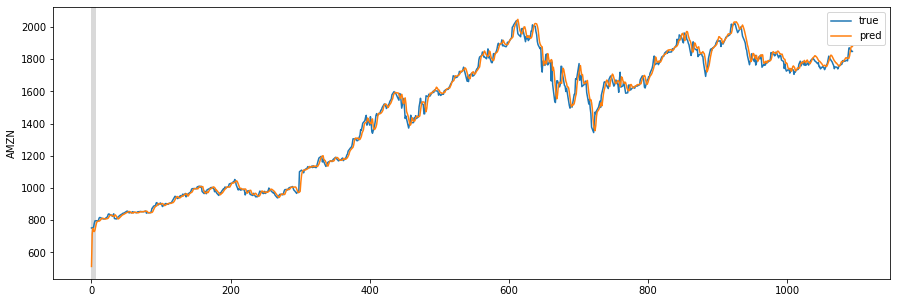

# Task 4 ---> MULTILABEL

***rnn_model_gru_linear_14, run #14:***<pre>

**Model Description**
This Model contains GRU as a dense layer and is used to forecast stocks as Adobe and Apple. 
Also, Linear Activation function has been used.

This run generates the best results with valid MAE as 0.01551 
Moreover, the graph indicates the quality of this forecasting.

**Optimizer Used**
Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

**Data**
stocks = ['Date', 'Day', 'HPQ', 'INTC','AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT']
labels = ['ADBE', 'AAPL']
horizon = 2

**Performance**
Train MAE: 0.00328
Valid MAE: 0.01551




**Training History**

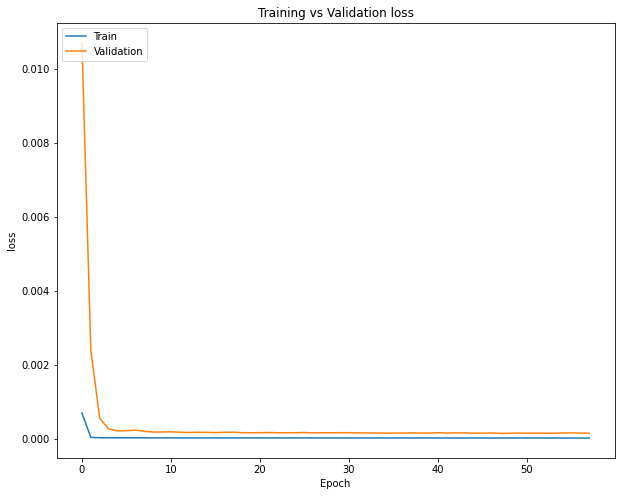

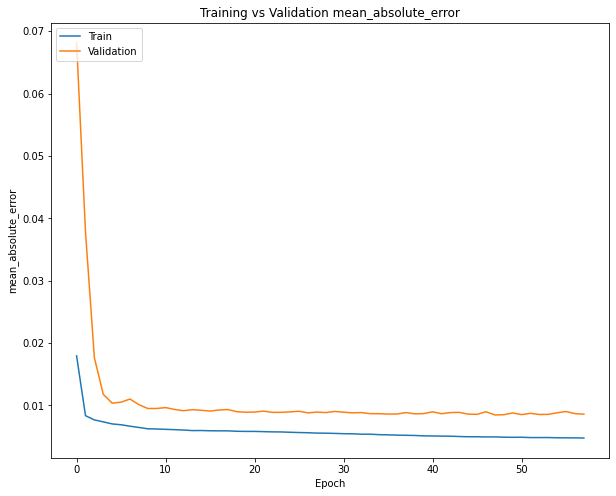

**Training Results**

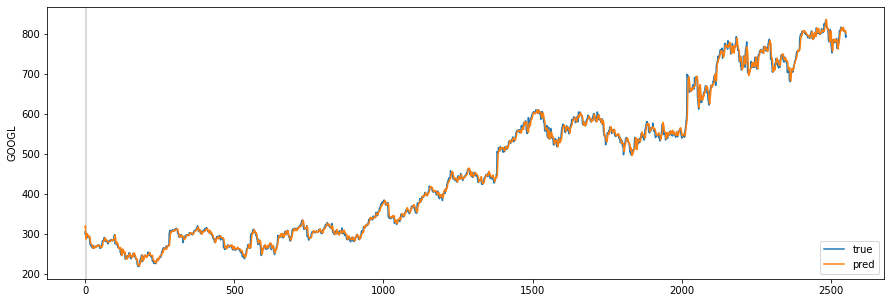


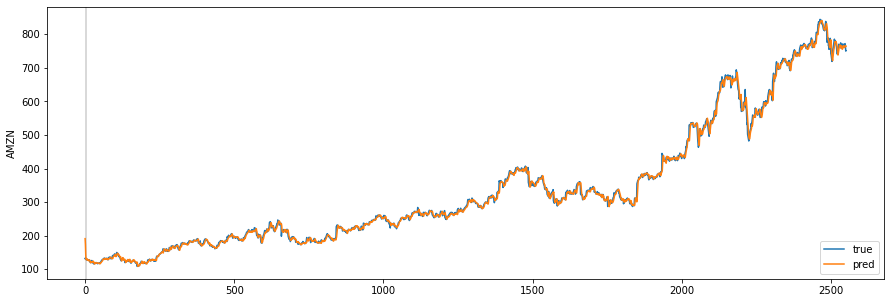


**Testing Results**

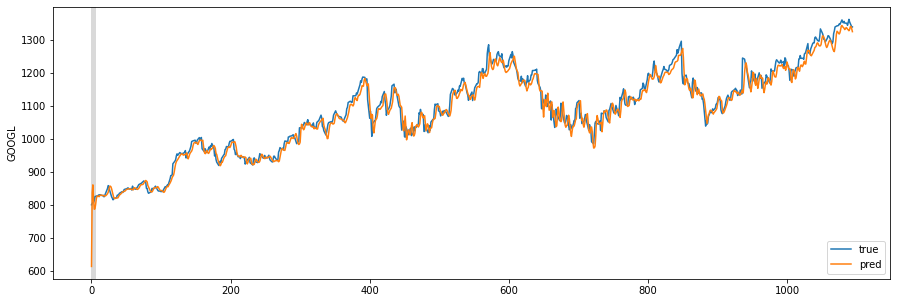

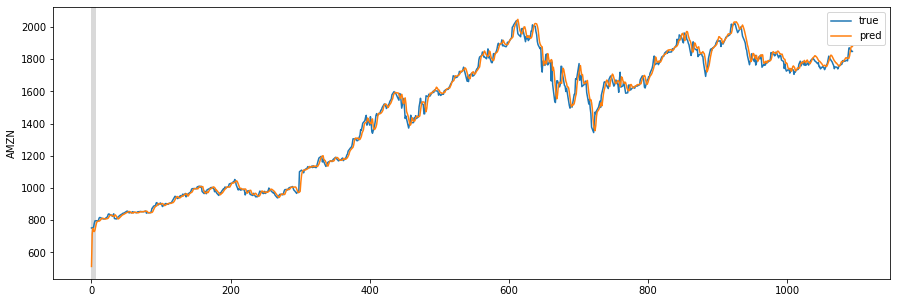

# Task 5 ---> Model Optimization

***rnn_model_gru_linear_16, run #16:***<pre>

**Model Description**
This model optimizes the best model generated in Multilabel mode by adding the batch normalization function.

Also, the results generated in this run are very good with Validation MAE as 0.00931. 

**Optimizer Used**
Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)

**Data**
stocks = ['Date', 'Day', 'HPQ', 'INTC','AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT']
labels = ['ADBE', 'AAPL']
horizon = 2

**Performance**
Train MAE: 0.00409
Valid MAE: 0.00931





**Training History**


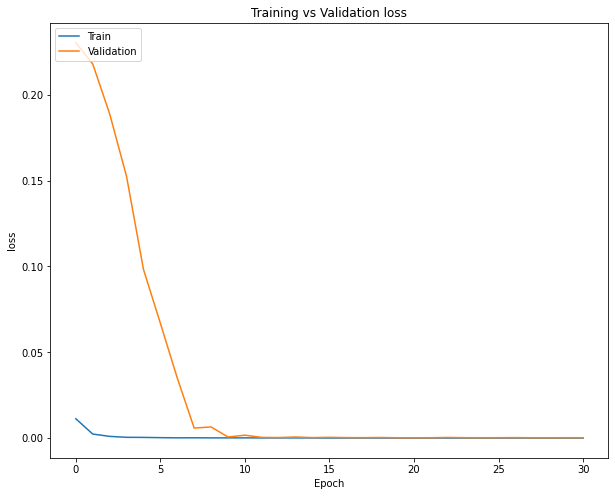

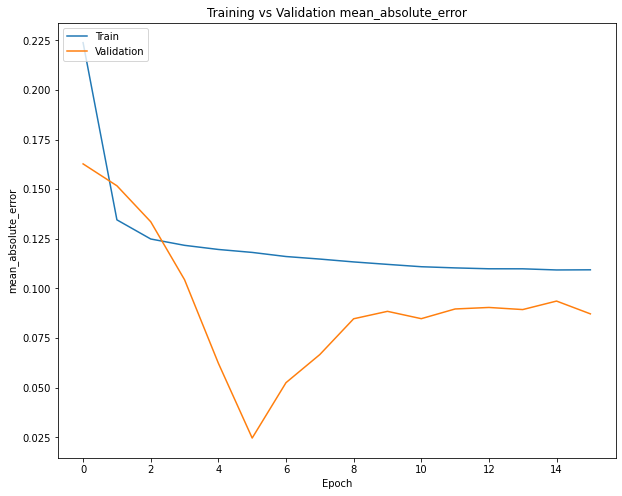

**Training Results**

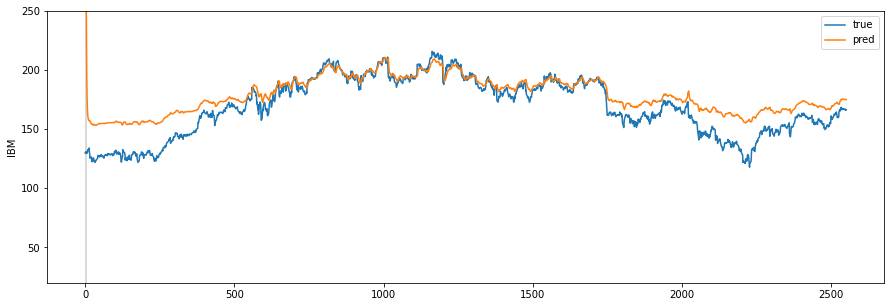

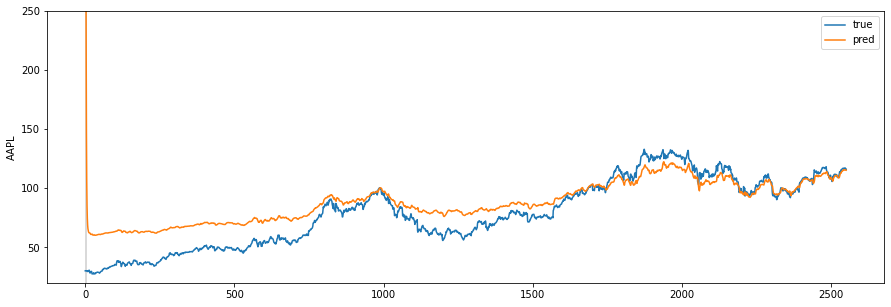

**Testing Results**

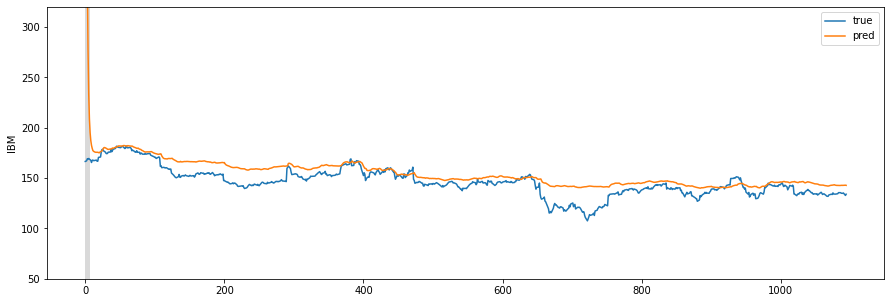

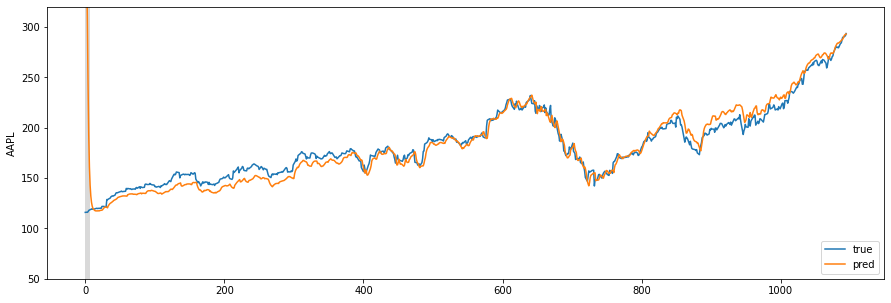

# Task 5.2 Without Custom Loss Function

***rnn_model_gru_linear_16, run #17:***<pre>

**Model Description**
This model is generated without using Custom Loss Function.

There is a small difference in the results generated using the default loss function. 
The result with Custom loss function is 0.00931 and without using it is 0.01034. 

The number of Epochs are almost same with and without Custom Loss Function. 

Overall, it could be concluded that it is better to use Custom Loss Function
to see the improved Results.

**Optimizer Used**
Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)

**Data**
stocks = ['Date', 'Day', 'HPQ', 'INTC','AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT']
labels = ['ADBE', 'AAPL']
horizon = 2

**Performance**
Train MAE: 0.00309
Valid MAE: 0.01034





**Training History**

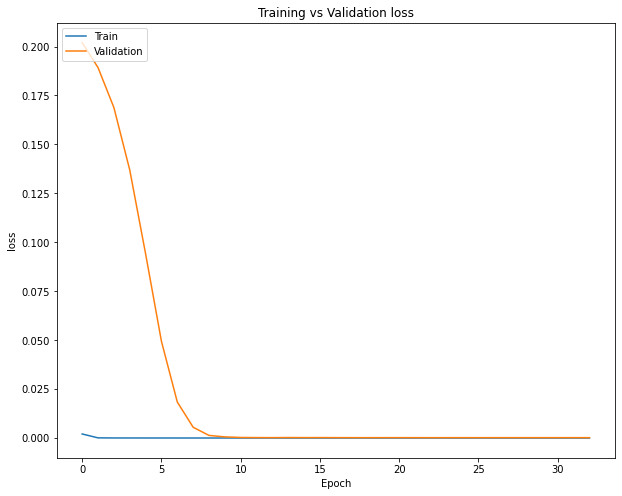

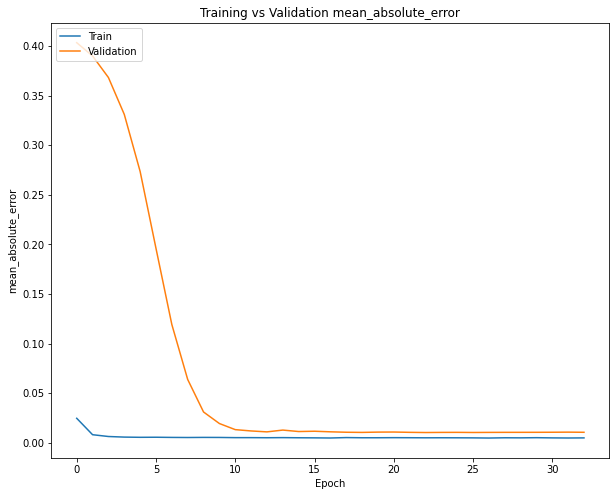

**Training Results**

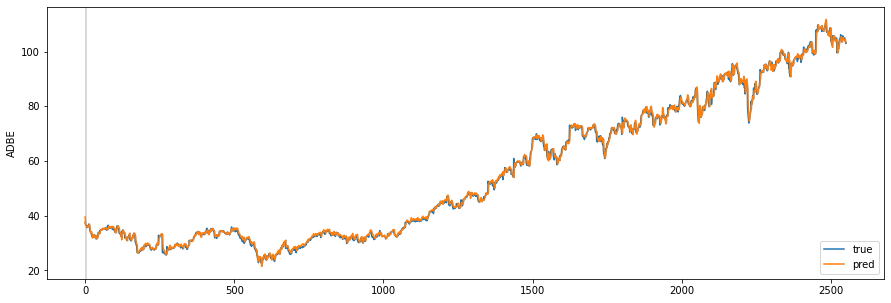

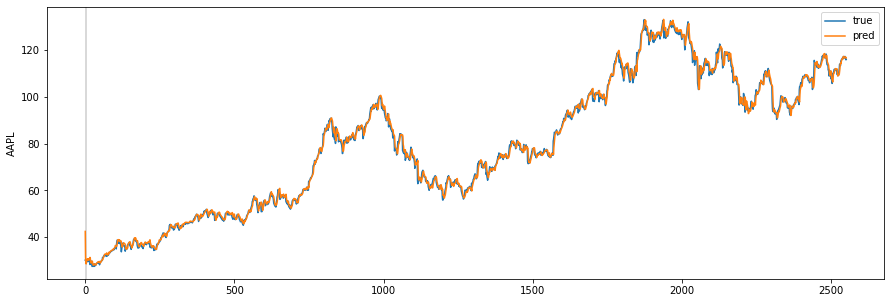

**Testing Results**


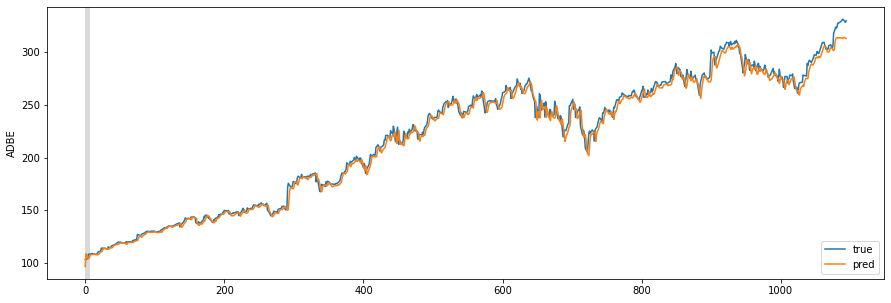

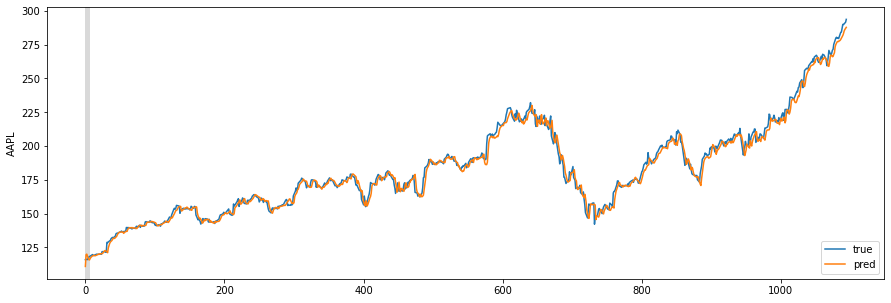

# Task 6 (Horizon = 7)

## Best Multilabel Optimized Model for Horizon = 7

***rnn_model_gru_linear_16, run #18:***<pre>

**Model Description**
This Model is the best Multilabel Optimized Model used to forecast for Horizon as 7.

This run generates the best results with valid MAE as 0.01730 
which is good for forecasting Multilabel Models. 

Moreover, the graph indicates the quality of this forecasting.

**Optimizer Used**
Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)

**Data**
stocks = ['Date', 'Day', 'HPQ', 'INTC','AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT']
labels = ['ADBE', 'AAPL']
horizon = 7

**Performance**
Train MAE: 0.00959
Valid MAE: 0.01730

**Training History**

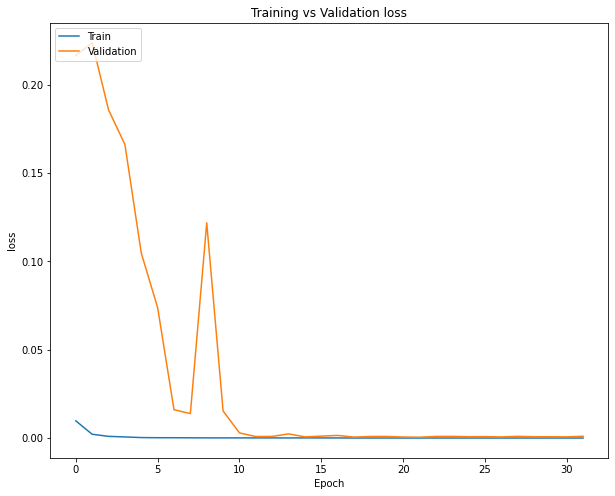

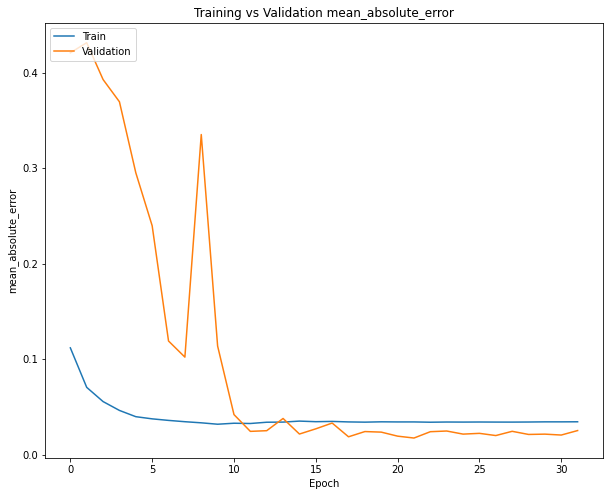

**Training Results**

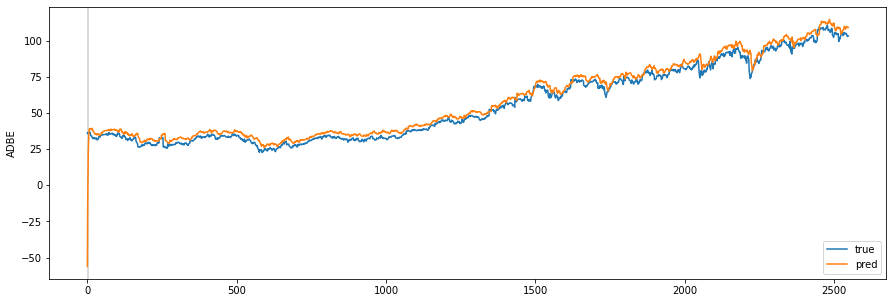

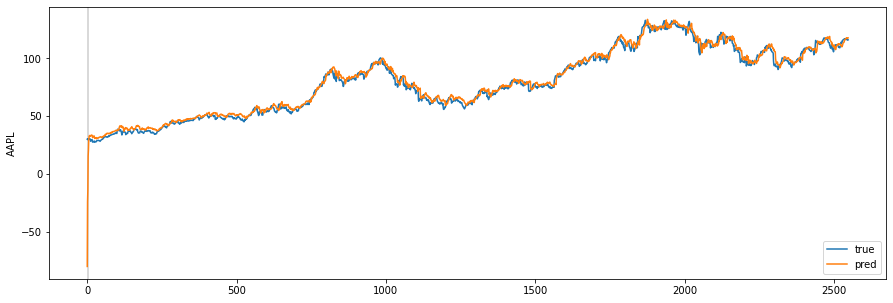

**Testing Results**

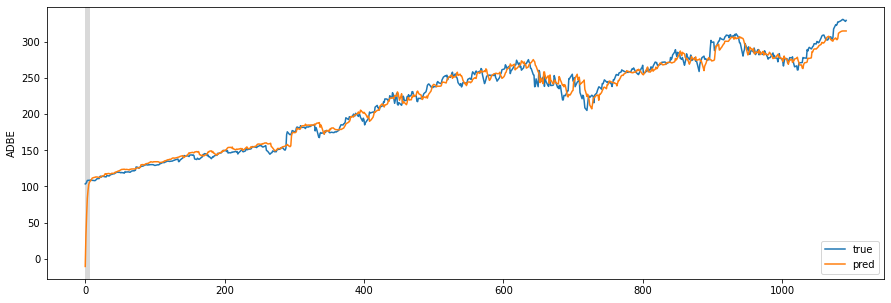

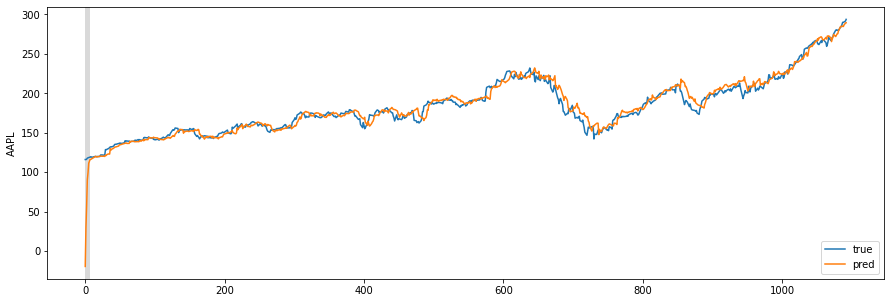

## Best Univariate Model for Horizon = 7

***rnn_model_gru_linear_1, run #19:***<pre>

**Model Description**
This Model is the best Univariate Optimized Model used to forecast for Horizon as 7.

This run generates the best results with valid MAE as 0.01069 
which is a very good for forecasting Univariate Models. 

Moreover, the graph indicates the quality of this forecasting.

**Optimizer Used**
Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)	

**Data**
stocks = ['Date', 'Day', 'MSFT']
labels = ['MSFT']
horizon = 7

**Performance**
Train MAE: 0.00370
Valid MAE: 0.01069

**Training History**

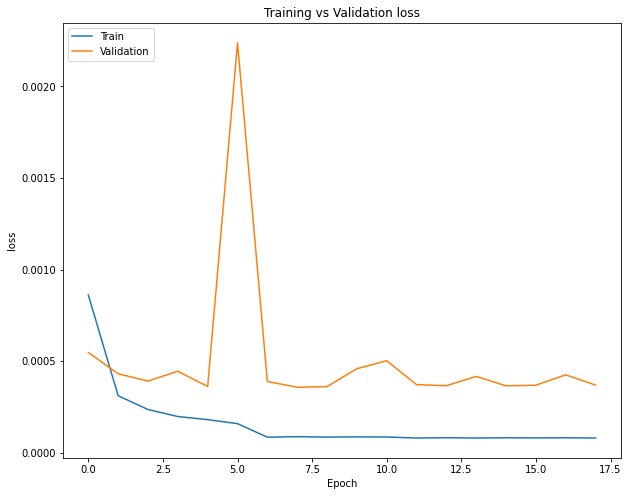

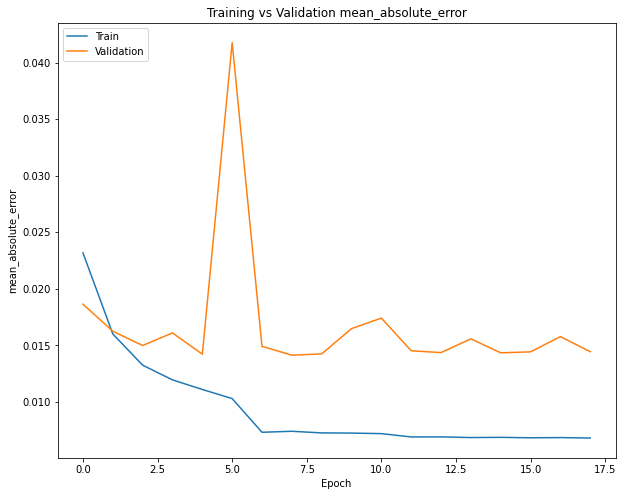

**Training Results**

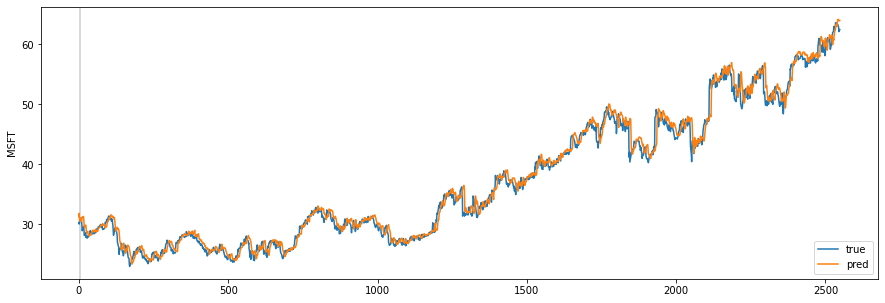

**Testing Results**

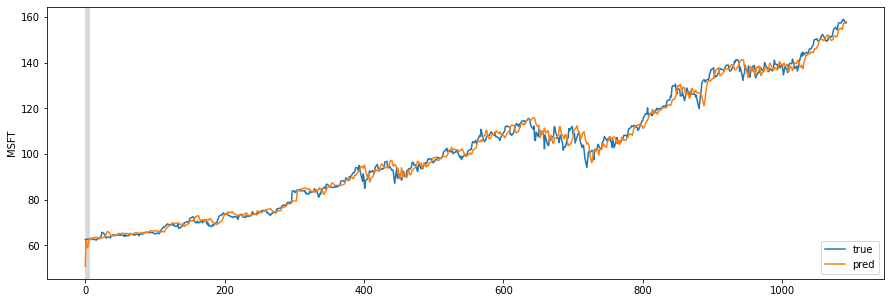

## Best Multivariate when Horizon is 7

***rnn_model_gru_linear_9, run #20:***<pre>

**Model Description**
This Model is the best Univariate Optimized Model used to forecast for Horizon as 7.

This run generates the best results with valid MAE as 0.00847 
which is a very good for forecasting Multivariate Models. 

Moreover, the graph indicates the quality of this forecasting.

**Optimizer Used**
Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

**Data**
stocks = ['Date', 'Day', 'HPQ', 'INTC','AAPL', 'ADBE', 'AMZN', 'GOOGL', 'IBM', 'MSFT']
labels = ['GOOGL', 'AMZN']
horizon = 7

**Performance**
Train MAE: 0.00268
Valid MAE: 0.00847

**Training History**

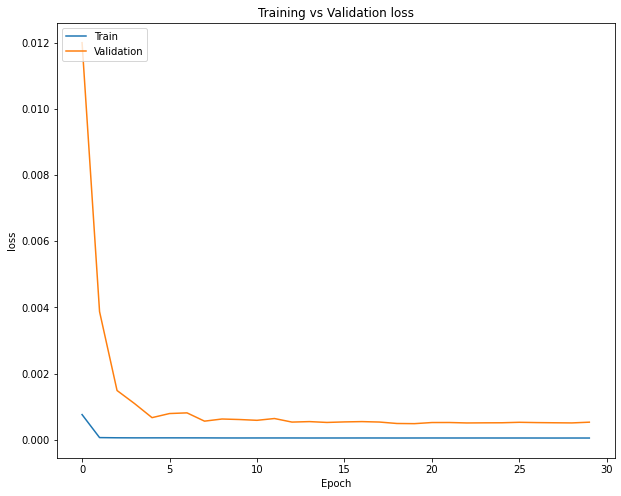

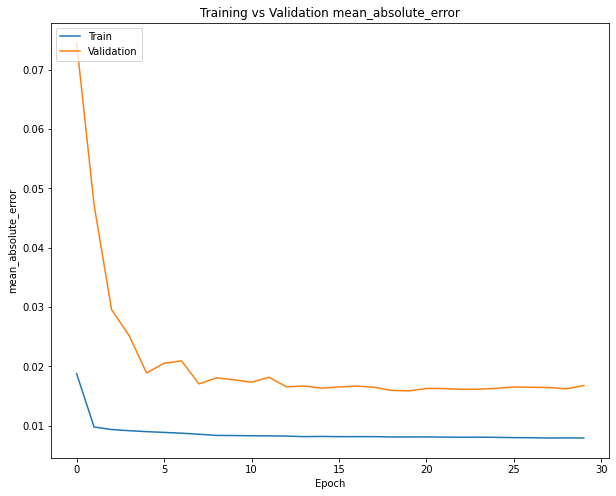

**Training Results**

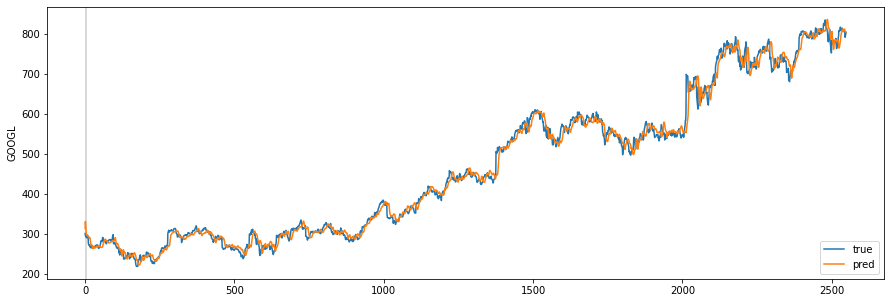

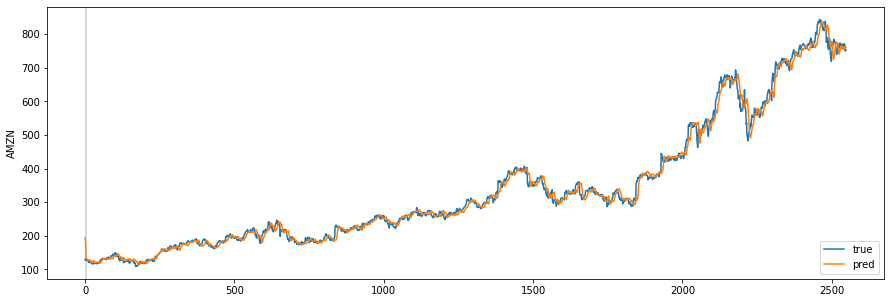

**Testing Results**

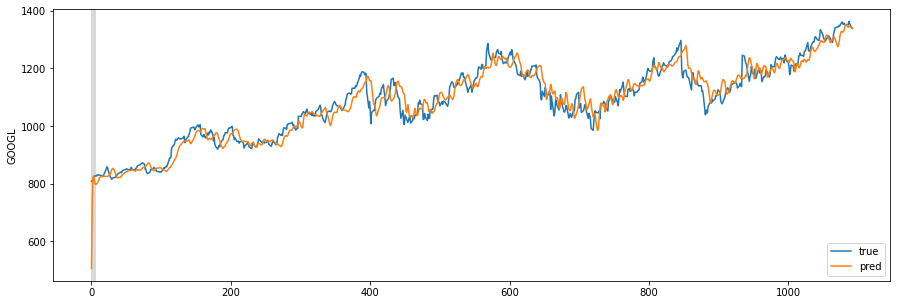


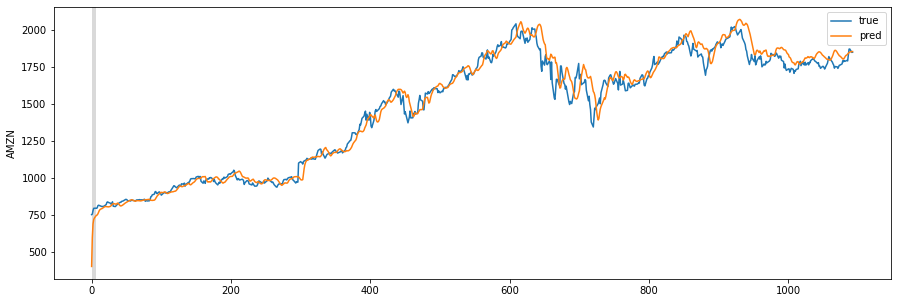